In [1]:
%run load_base_runs.ipynb

In [2]:
import pandas
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from mlflow import MlflowClient
import mlflow
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import collections
import matplotlib as mpl
import numpy as np
from collections import defaultdict
import scienceplots
from sklearn import datasets
from pathlib import Path
from sklearn.datasets import make_blobs

from cycler import cycler
plt.style.use(['science', 'bright'])


In [4]:
OPTIMAL_CENTROID_PARAMS = ['params.subspaces', 'metrics.should_take_tree']

In [5]:
if cached("07.08-optimal-centroids-no-depth"):
    optimal_centroid_runs_df = load_cache("07.08-optimal-centroids-no-depth")
else:
    optimal_centroid_runs_df =get_runs_for("07.08-optimal-centroids-no-depth")\
        .assign(cls_report=lambda row: row['artifact_uri'].apply(lambda v: get_metrics(v, "cls_report.json")))\
        .assign(imb_cls_report=lambda row: row['artifact_uri'].apply(lambda v: get_metrics(v, "imb_cls_report.json")))\
        .assign(complex_dt=lambda row: row['artifact_uri'].apply(lambda v: get_metrics(v, "complex_dt.json")))\
        [CLASSIFICATION_METRICS + DATASET_PARAMS + RF_METRICS + OPTIMAL_CENTROID_PARAMS + ['complex_dt']] \
        .assign(**classification_metrics_extractors)\
        .assign(complexity=lambda row: row['complex_dt'].apply(calculate_rf_compexity))

In [6]:
cache(optimal_centroid_runs_df, "07.08-optimal-centroids-no-depth")

In [7]:
def get_convergence(row):
    artifact_uri = row['artifact_uri']
    return mlflow.artifacts.load_dict(f"{artifact_uri}/convergence_history.json")['data']

In [8]:
# optimal_centroid_runs_df['convergence'] = optimal_centroid_runs_df.apply(get_convergence, axis=1)

In [9]:
base_runs_rf.rename(columns={c: c+'_rf' for c in base_runs_rf.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_dt.rename(columns={c: c+'_dt' for c in base_runs_dt.columns if 'metric' in c  or 'test_' in c}, inplace=True)
base_runs_greedy.rename(columns={c: c+'_greedy' for c in base_runs_greedy.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_oner.rename(columns={c: c+'_oner' for c in base_runs_oner.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_rulefit.rename(columns={c: c+'_rulefit' for c in base_runs_rulefit.columns if 'metric' in c or 'test_' in c}, inplace=True)


In [10]:
base_runs_together_df = pd.merge(
    base_runs_dt,
    base_runs_rf,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('_dt', '_rf')
)\
    .merge(base_runs_greedy, how='right', on=DATASET_PARAMS, suffixes=('', '_greedy'))\
    .merge(base_runs_oner, how='right', on=DATASET_PARAMS, suffixes=('', '_oner'))\
    .merge(base_runs_rulefit, how='right', on=DATASET_PARAMS, suffixes=('', '_rulefit'))\
    .dropna()
optimal_centroids_df = pd.merge(
    base_runs_together_df,
    optimal_centroid_runs_df,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('', '_opt')
)
optimal_centroids_df = pd.merge(
    optimal_centroids_df,
    complexities_df,
    how='left',
    on=DATASET_PARAMS
)

In [11]:
optimal_centroids_df.dropna(inplace=True)

In [12]:
# optimal_centroids_df['test_accuracy'] = optimal_centroids_df.apply(lambda row: row['test_accuracy_dt'] if row['metrics.should_take_tree'] == True else row['test_accuracy'], axis=1)

In [13]:
# optimal_centroids_df['metrics.should_take_tree'] == True

In [14]:
# optimal_centroids_df.apply(lambda row: row['test_accuracy_dt'] if row['metrics.should_take_tree'] == True else row['test_accuracy'], axis=1)

In [15]:
LABELS_THAT_SHOULD_BE =["better", "equal", "worse"] 

In [16]:
def make_sure_all_labels_are_there(df):
    missing_labels = set(LABELS_THAT_SHOULD_BE) - set(df.index)

    for label in missing_labels:
        df.loc[label] = pd.Series()

    return df.reindex(LABELS_THAT_SHOULD_BE)

In [17]:
def get_subspace_plot_values(param):
    subspace_plot_values = optimal_centroids_df.groupby('params.subspaces')[param].mean().to_dict()
    return dict(sorted({int(k):round(v, 3) for k,v in subspace_plot_values.items()}.items()))



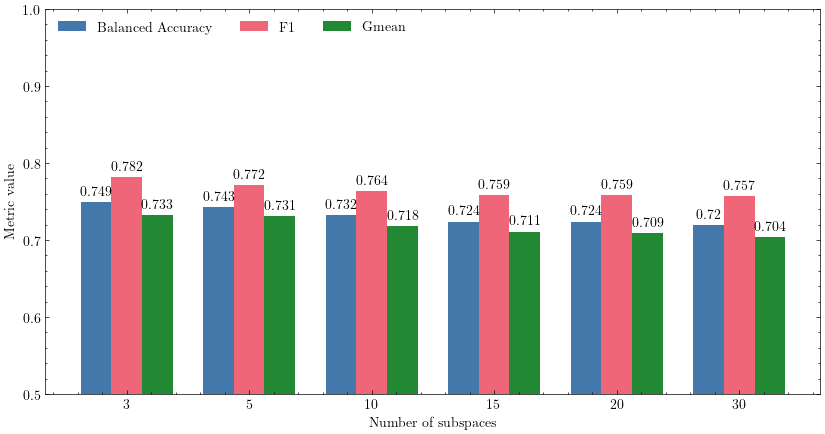

In [18]:
species = (3, 5, 10, 15, 20, 30)
penguin_means = {
    'Balanced Accuracy': list(get_subspace_plot_values("test_balanced_accuracy").values()),
    'F1': list(get_subspace_plot_values("test_f1").values()),
    'Gmean': list(get_subspace_plot_values("test_geometric_mean").values()),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 5))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_title('Measures per ')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Number of subspaces")
ax.set_ylabel("Metric value")

plt.show()

fig.savefig("../figures/optimal/subspace-performances.pdf")

In [19]:
METRICS = list(classification_metrics_extractors.keys())
METRICS

['test_index_balanced_accuracy',
 'test_geometric_mean',
 'test_f1',
 'test_specificity',
 'test_recall',
 'test_precision',
 'test_balanced_accuracy',
 'test_accuracy']

In [20]:
SUFFIXES = ["_dt", "_rf", "_oner", "_rulefit", "_greedy"]

In [21]:
def define_comparison(row, suffix, metric):
    if row[f'{metric}_equal{suffix}']:
        return "equal"
    if row[f'{metric}_better{suffix}']:
        return "better"
    else:
        return "worse"

In [22]:
for suffix in SUFFIXES:
    for metric in METRICS:
        optimal_centroids_df[f'{metric}_diff_to{suffix}'] = optimal_centroids_df[metric] - optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_better_equal{suffix}'] = optimal_centroids_df[metric] >= optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_better{suffix}'] = optimal_centroids_df[metric] > optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_worse{suffix}'] = ~optimal_centroids_df[f'{metric}_better_equal{suffix}']
        optimal_centroids_df[f'{metric}_worse_equal{suffix}'] = ~optimal_centroids_df[f'{metric}_better{suffix}']
        optimal_centroids_df[f'{metric}_equal{suffix}'] = optimal_centroids_df[metric] == optimal_centroids_df[f'{metric}{suffix}']
        optimal_centroids_df[f'{metric}_comparison{suffix}'] = optimal_centroids_df.apply(lambda row: define_comparison(row, suffix, metric), axis=1)

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_54543/728790332.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  optimal_centroids_df[f'{metric}_comparison{suffix}'] = optimal_centroids_df.apply(lambda row: define_comparison(row, suffix, metric), axis=1)
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_54543/728790332.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  optimal_centroids_df[f'{metric}_diff_to{suffix}'] = optimal_centroids_df[metric] - optimal_centroids_df[f'{metric}{suffix}']
/var/folders/

In [23]:
QCUT_BINS = {}

In [24]:
for metric in COMPLEXITY_METRICS:
    series, bins = pd.qcut(optimal_centroids_df[metric], 3, labels=["low", "medium", "high"], retbins=True)
    optimal_centroids_df[f'{metric}-discretized'] = series
    QCUT_BINS[metric] = bins

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_54543/2365732514.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  optimal_centroids_df[f'{metric}-discretized'] = series
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_54543/2365732514.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  optimal_centroids_df[f'{metric}-discretized'] = series
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_54543/2365732514.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [25]:
ALL_DISCRETIZED_METRICS = [f'{metric}-discretized' for metric in COMPLEXITY_METRICS]

In [26]:
compare_values = {
    "low": 0,
    "medium": 1,
    "high": 2,
}
compare_values_inverted = {
    v: k for k, v in compare_values.items()
}
def take_higher(row):
    vals = [compare_values[it] for it in [row[0], row[1]]]
    max_val = max(vals)
    
    return compare_values_inverted[max_val]

In [27]:
optimal_centroids_df['overall-complexity'] = optimal_centroids_df[ALL_DISCRETIZED_METRICS].mode(axis=1).fillna('low').apply(take_higher, axis=1)

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_54543/655859473.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  optimal_centroids_df['overall-complexity'] = optimal_centroids_df[ALL_DISCRETIZED_METRICS].mode(axis=1).fillna('low').apply(take_higher, axis=1)


# COMPARISON TO ALGORITHSM

In [28]:
LIMITING_QUERY = "`params.subspaces` == '3'"

In [29]:
COMPARED_ALGS = ['rf', 'dt']

In [30]:
[c for c in optimal_centroids_df.columns if "comparison" in c.lower()]

['test_index_balanced_accuracy_comparison_dt',
 'test_geometric_mean_comparison_dt',
 'test_f1_comparison_dt',
 'test_specificity_comparison_dt',
 'test_recall_comparison_dt',
 'test_precision_comparison_dt',
 'test_balanced_accuracy_comparison_dt',
 'test_accuracy_comparison_dt',
 'test_index_balanced_accuracy_comparison_rf',
 'test_geometric_mean_comparison_rf',
 'test_f1_comparison_rf',
 'test_specificity_comparison_rf',
 'test_recall_comparison_rf',
 'test_precision_comparison_rf',
 'test_balanced_accuracy_comparison_rf',
 'test_accuracy_comparison_rf',
 'test_index_balanced_accuracy_comparison_oner',
 'test_geometric_mean_comparison_oner',
 'test_f1_comparison_oner',
 'test_specificity_comparison_oner',
 'test_recall_comparison_oner',
 'test_precision_comparison_oner',
 'test_balanced_accuracy_comparison_oner',
 'test_accuracy_comparison_oner',
 'test_index_balanced_accuracy_comparison_rulefit',
 'test_geometric_mean_comparison_rulefit',
 'test_f1_comparison_rulefit',
 'test_speci

In [31]:
optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .pivot_table(columns=['test_accuracy_comparison_rulefit'], aggfunc="count", values=["test_accuracy"])

test_accuracy_comparison_rulefit,better,equal,worse
test_accuracy,51,15,94


In [32]:
optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .pivot_table(columns=['test_f1_comparison_rulefit'], aggfunc="count", values=["test_f1"])

test_f1_comparison_rulefit,better,equal,worse
test_f1,59,10,91


In [33]:
optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .pivot_table(columns=['test_balanced_accuracy_comparison_rulefit'], aggfunc="count", values=["test_balanced_accuracy"])

test_balanced_accuracy_comparison_rulefit,better,equal,worse
test_balanced_accuracy,67,11,82


In [34]:
optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .pivot_table(columns=['test_balanced_accuracy_comparison_rulefit'], aggfunc="count", values=["test_balanced_accuracy"])

test_balanced_accuracy_comparison_rulefit,better,equal,worse
test_balanced_accuracy,67,11,82


In [35]:
optimal_centroids_df[['test_accuracy', 'test_precision']]

,test_accuracy,test_precision
0,0.865443,0.884139
1,0.755352,0.755015
2,0.865443,0.884139
3,0.865443,0.884139
4,0.807339,0.813093
...,...,...
955,0.917889,0.917630
956,0.912023,0.912945
957,0.906158,0.907774
958,0.912023,0.914327


In [36]:
def vals_to_percentage(l):
    total = sum(l)
    
    return [round(item/total*100,2) for item in l]
    

## WINS-LOSSES acc general

In [37]:
def plot_bar(labels, values_dict, quants, ax):
    plot_labels = [l.split('_')[-1].upper() for l in labels]
    data = np.array(list(values_dict.values()))
    data_cum = data.cumsum(axis=1)
        
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, colname in enumerate(quants):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)

        ax.bar_label(rects, label_type='center')




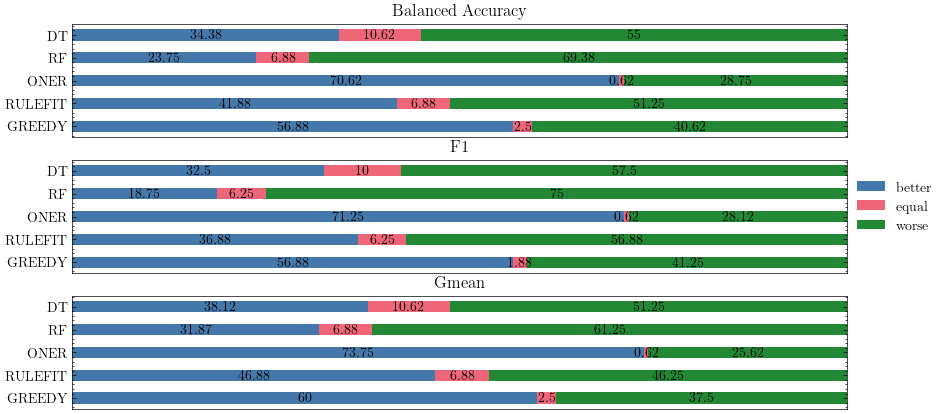

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 5))


ax1.set_title("Balanced Accuracy")
labels = [f"test_balanced_accuracy_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax1)

ax2.set_title("F1")
labels = [f"test_f1_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax2)


ax3.set_title("Gmean")
labels = [f"test_geometric_mean_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax3)

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

fig.savefig('../figures/optimal/overall-performance-barplot.pdf')

In [39]:
ACC_LABELS = [f"test_balanced_accuracy_comparison{suffix}" for suffix in SUFFIXES]
F1_LABELS = [f"test_f1_comparison{suffix}" for suffix in SUFFIXES]
GMEAN_LABELS = [f"test_geometric_mean_comparison{suffix}" for suffix in SUFFIXES]

In [40]:
vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in
                    
                    optimal_centroids_df\
    .query(LIMITING_QUERY)\
    .query("`n1-discretized` == 'low'")[ACC_LABELS].apply(pd.Series.value_counts).fillna(0).to_dict().items()}
vals_to_plot

{'test_balanced_accuracy_comparison_dt': [33.33, 16.67, 50.0],
 'test_balanced_accuracy_comparison_rf': [24.07, 18.52, 57.41],
 'test_balanced_accuracy_comparison_oner': [77.78, 0.0, 22.22],
 'test_balanced_accuracy_comparison_rulefit': [35.19, 20.37, 44.44],
 'test_balanced_accuracy_comparison_greedy': [70.37, 0.0, 29.63]}

In [41]:
COMPLEXITIES_TO_CONSIDER = ['f2', 't4', 'c1', 'n3', 'l2', 'density']

In [42]:
optimal_centroids_df.query(LIMITING_QUERY).query(f"`f2-discretized` == 'high'")[ACC_LABELS].apply(pd.Series.value_counts).to_dict()

{'test_balanced_accuracy_comparison_dt': {'better': 20,
  'equal': 11,
  'worse': 22},
 'test_balanced_accuracy_comparison_rf': {'better': 21,
  'equal': 8,
  'worse': 24},
 'test_balanced_accuracy_comparison_oner': {'better': 42.0,
  'equal': nan,
  'worse': 11.0},
 'test_balanced_accuracy_comparison_rulefit': {'better': 22,
  'equal': 9,
  'worse': 22},
 'test_balanced_accuracy_comparison_greedy': {'better': 32,
  'equal': 1,
  'worse': 20}}

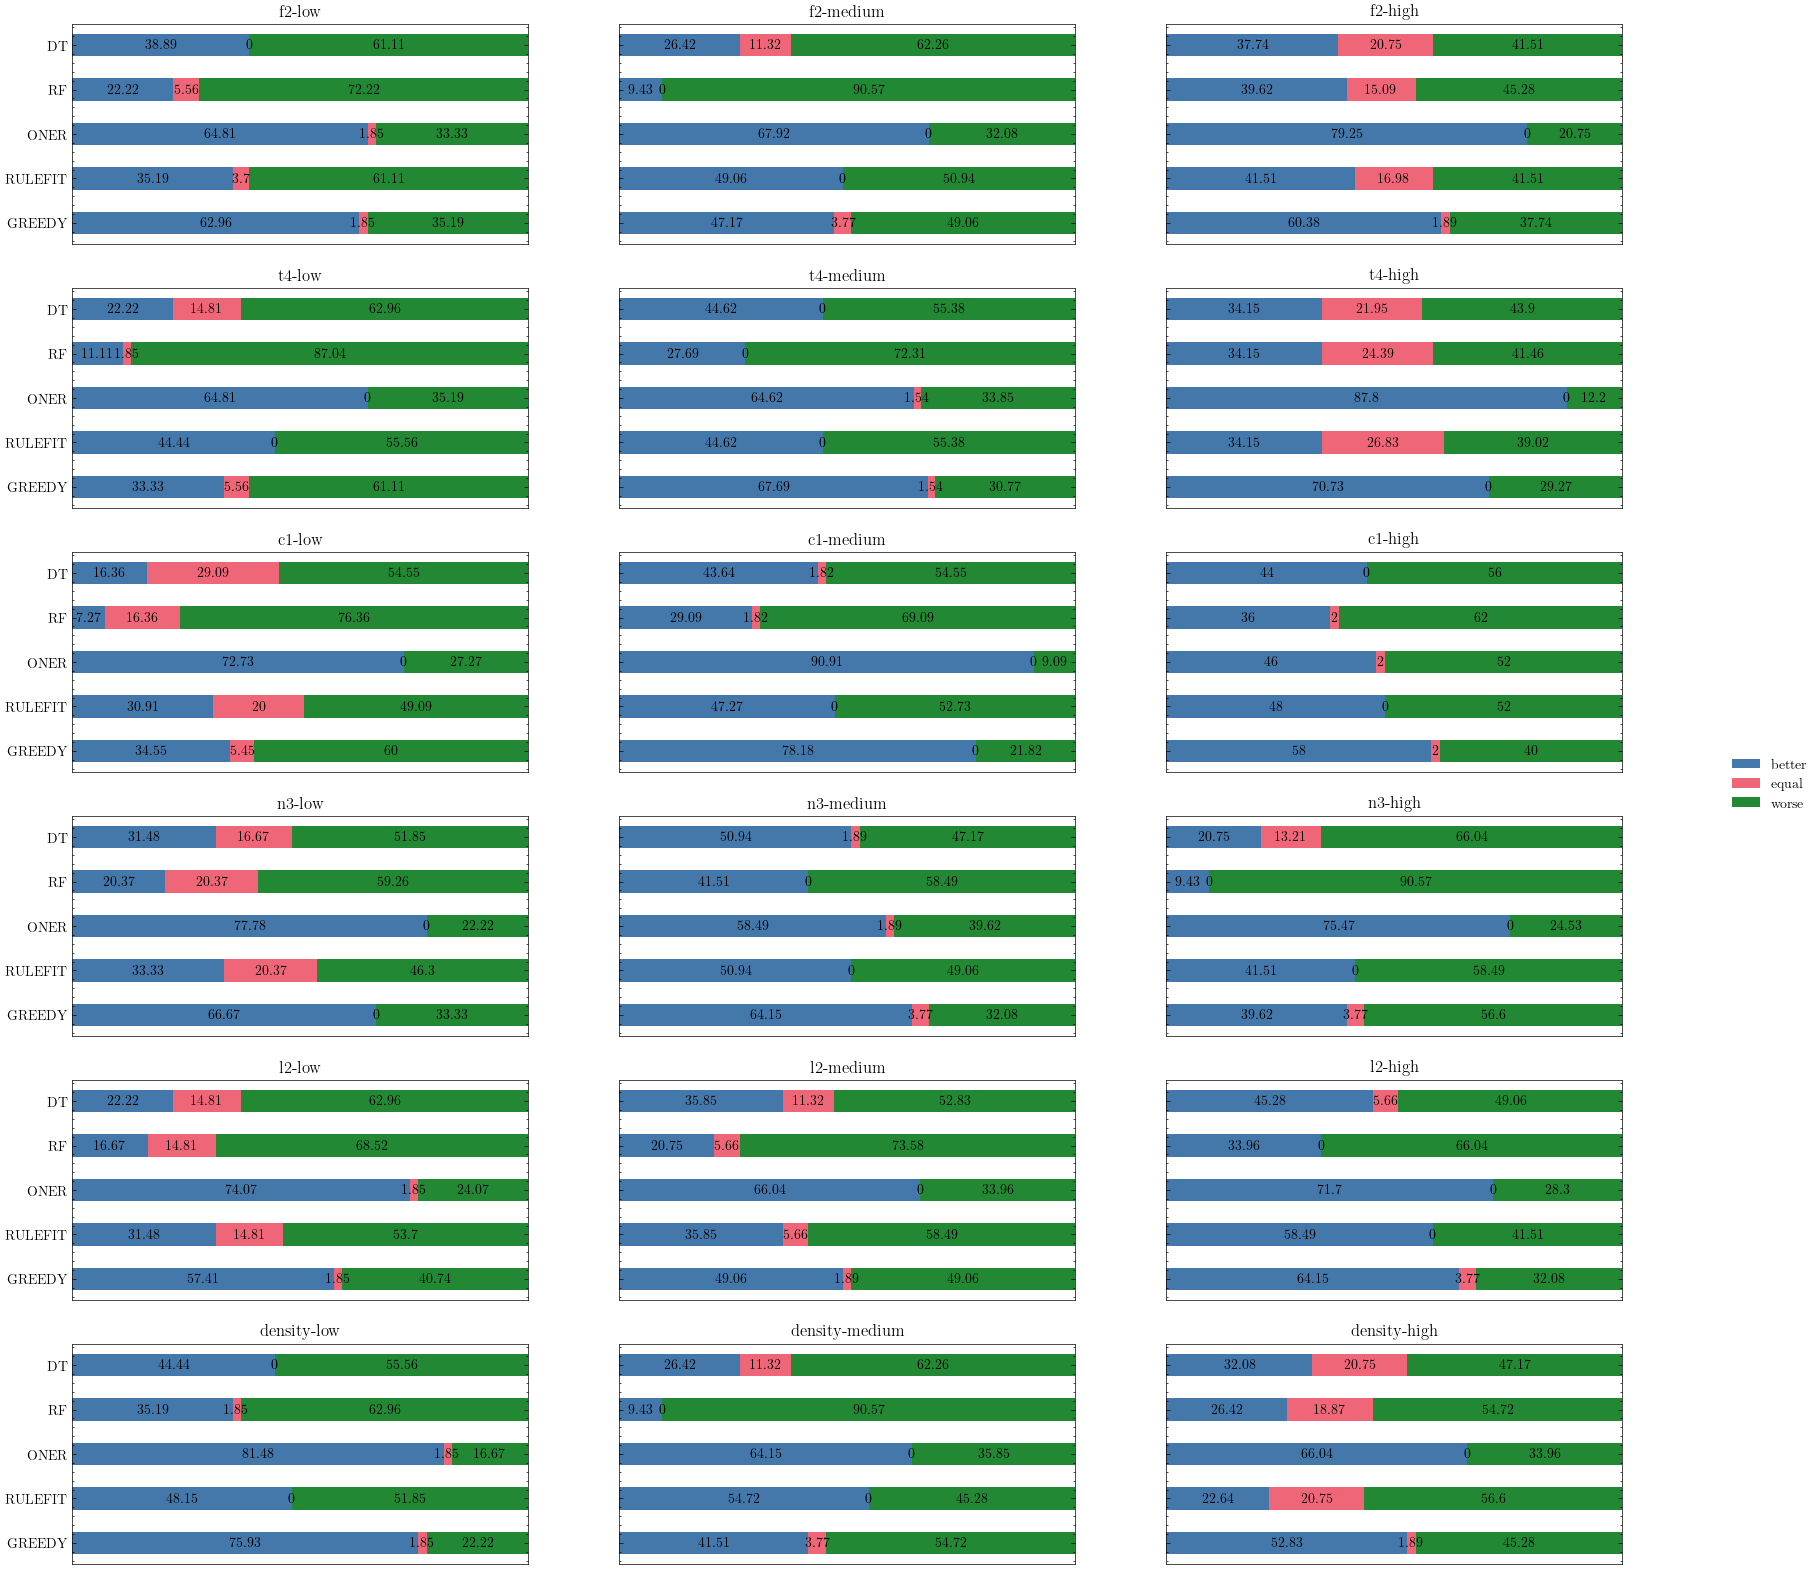

In [43]:
fig, axes = plt.subplots(len(COMPLEXITIES_TO_CONSIDER),3,figsize=(20, 20), sharey='row')

axes = axes.reshape(-1)

axes_iter = iter(axes)
for complexity in COMPLEXITIES_TO_CONSIDER:
    plot_labels = [l.split('_')[-1].upper() for l in ACC_LABELS]
    
    
    for value in ['low', 'medium', 'high']:

        ax = next(axes_iter)
        vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY).query(f"`{complexity}-discretized` == '{value}'")[ACC_LABELS].apply(pd.Series.value_counts).fillna(0).to_dict().items()}

        data = np.array(list(vals_to_plot.values()))
        data_cum = data.cumsum(axis=1)
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())
    
        for i, colname in enumerate(['better', 'equal', 'worse']):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
            ax.bar_label(rects, label_type='center')
    
        ax.set_title(f"{complexity}-{value}")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.savefig('../figures/optimal/accuracy-with-variance-complexity-metrics-barplot.pdf')


In [44]:
def get_weighted_variances_merics(metric):
    variances = optimal_centroids_df\
    .query(LIMITING_QUERY) \
    [[metric] + ALL_DISCRETIZED_METRICS] \
    .melt(metric)\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')[metric].var()
    
    weighted_variances = variances.apply(lambda it: it/variances.sum())
    
    return weighted_variances.sort_values(ascending=False)


In [46]:
LABELS = ['test_balanced_accuracy_better_rf', 'test_balanced_accuracy_better_dt', 'test_f1_better_rf', 'test_f1_better_dt', 'test_geometric_mean_better_rf', 'test_geometric_mean_better_dt']

In [47]:
summed_variances = None

for metric in LABELS:
    if summed_variances is None:
        summed_variances = get_weighted_variances_merics(metric)
    else:
        summed_variances = summed_variances + get_weighted_variances_merics(metric)
        

In [48]:
summed_variances = summed_variances.sort_values(ascending=False)[:6].rename(lambda it: it.split("-")[0])
summed_variances

variable
n2     0.741411
f1     0.482512
c1     0.451672
c2     0.451672
f1v    0.450707
n3     0.382589
dtype: float64

In [49]:
COMPLEXITIES_WITH_HIGHEST_VARIANCE = summed_variances.index.tolist()

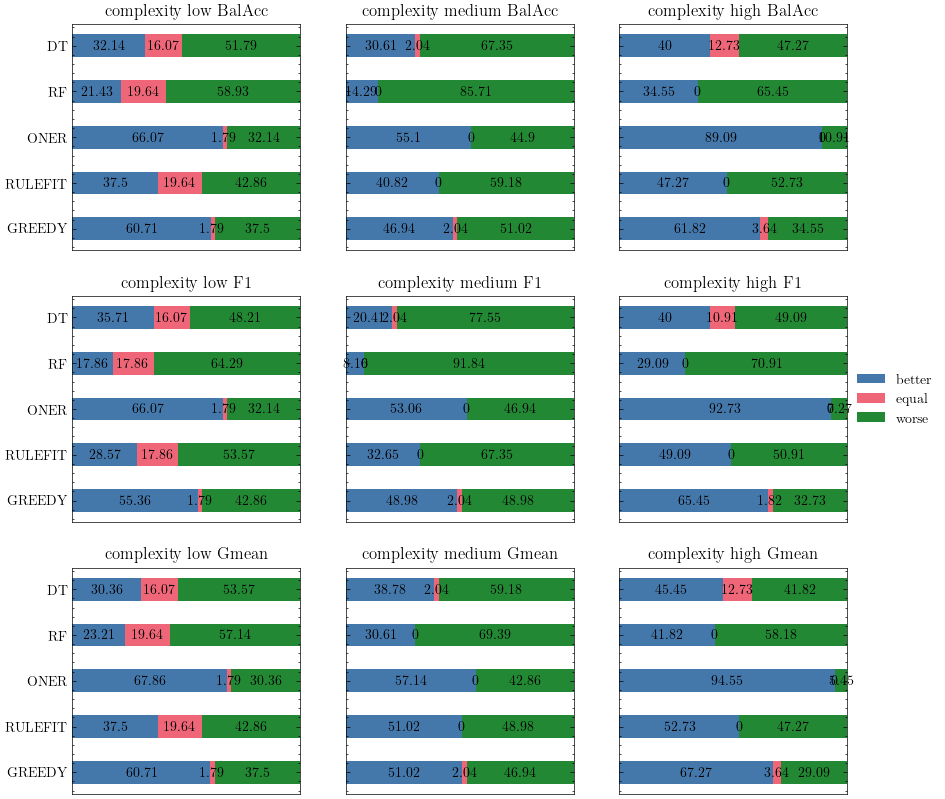

In [50]:
fig, axes = plt.subplots(3,3, sharey=True, figsize=(10, 10))

axes = axes.reshape(-1)

axes_iter = iter(axes)
plot_labels = [l.split('_')[-1].upper() for l in ACC_LABELS]



for labels, label in zip([ACC_LABELS, F1_LABELS, GMEAN_LABELS], ["BalAcc", "F1", "Gmean"]):
    for value in ['low', 'medium', 'high']:
        ax = next(axes_iter)
        vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in optimal_centroids_df.query(LIMITING_QUERY).query(f"`overall-complexity` == '{value}'")[labels].apply(pd.Series.value_counts).fillna(0).to_dict().items()}
    
        data = np.array(list(vals_to_plot.values()))
        data_cum = data.cumsum(axis=1)
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        # ax.yaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())
    
        for i, colname in enumerate(['better', 'equal', 'worse']):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
            ax.bar_label(rects, label_type='center')
    
        ax.set_title(f"complexity {value} {label}")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.savefig("../figures/optimal/accuracy-overall-complexity-barplot.pdf")

In [51]:
def plot_wins_variance(metric):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 7))

    metric_full_name_rf = f"{metric}_better_rf"
    metric_full_name_dt = f"{metric}_better_dt"
    
    optimal_centroids_df\
        .query(LIMITING_QUERY) \
        [[metric_full_name_rf] + ALL_DISCRETIZED_METRICS] \
        .melt(metric_full_name_rf)\
        .groupby(['variable', 'value'], as_index=False)[metric_full_name_rf].var()\
        .groupby('variable')[metric_full_name_rf].var()\
        .rename(index=lambda name: name.split('-')[0]).plot(kind='pie', ax=ax1)
    
    ax1.set_title("Variance of wins against Random Forest")
    
    optimal_centroids_df\
        .query(LIMITING_QUERY) \
        [[metric_full_name_dt] + ALL_DISCRETIZED_METRICS] \
        .melt(metric_full_name_dt)\
        .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
        .groupby('variable')[metric_full_name_dt].var()\
        .rename(index=lambda name: name.split('-')[0]).plot(kind='pie', ax=ax2)

    ax2.set_title("Variance of wins against Decision Tree")
    return fig
    

In [52]:
def get_best_var_merics(metric, how_many=3):
    return list(optimal_centroids_df\
    .query(LIMITING_QUERY) \
    [[metric] + ALL_DISCRETIZED_METRICS] \
    .melt(metric)\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')[metric].var().sort_values(ascending=False)[:how_many].index)

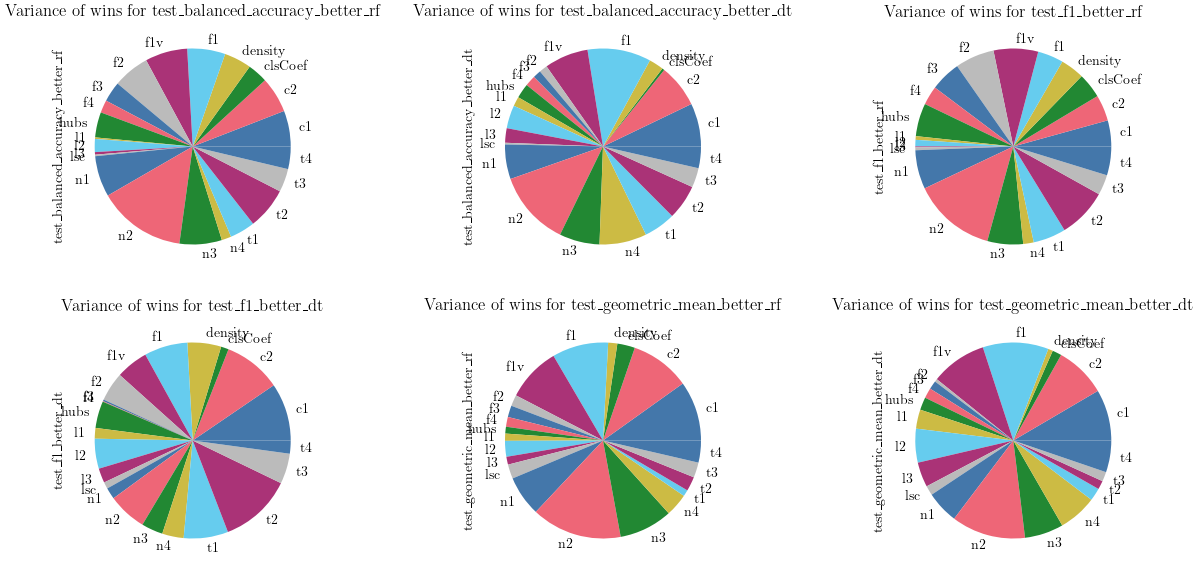

In [53]:
fig, axes = plt.subplots(2, 3,figsize=(15, 7))

axes = axes.reshape(-1)

axes_iter = iter(axes)

for metric in LABELS:
    ax = next(axes_iter)
    optimal_centroids_df\
        .query(LIMITING_QUERY) \
        [[metric] + ALL_DISCRETIZED_METRICS] \
        .melt(metric)\
        .groupby(['variable', 'value'], as_index=False)[metric].apply(lambda x: np.sum(x)/len(x))\
        .groupby('variable')[metric].var()\
        .rename(index=lambda name: name.split('-')[0]).plot(kind='pie', ax=ax)

    ax.set_title(f"Variance of wins for {metric}")

fig.savefig('../figures/optimal/variance-of-wins.pdf')

In [54]:
summed_variances = None

for metric in LABELS:
    if summed_variances is None:
        summed_variances = get_weighted_variances_merics(metric)
    else:
        summed_variances = summed_variances + get_weighted_variances_merics(metric)
        

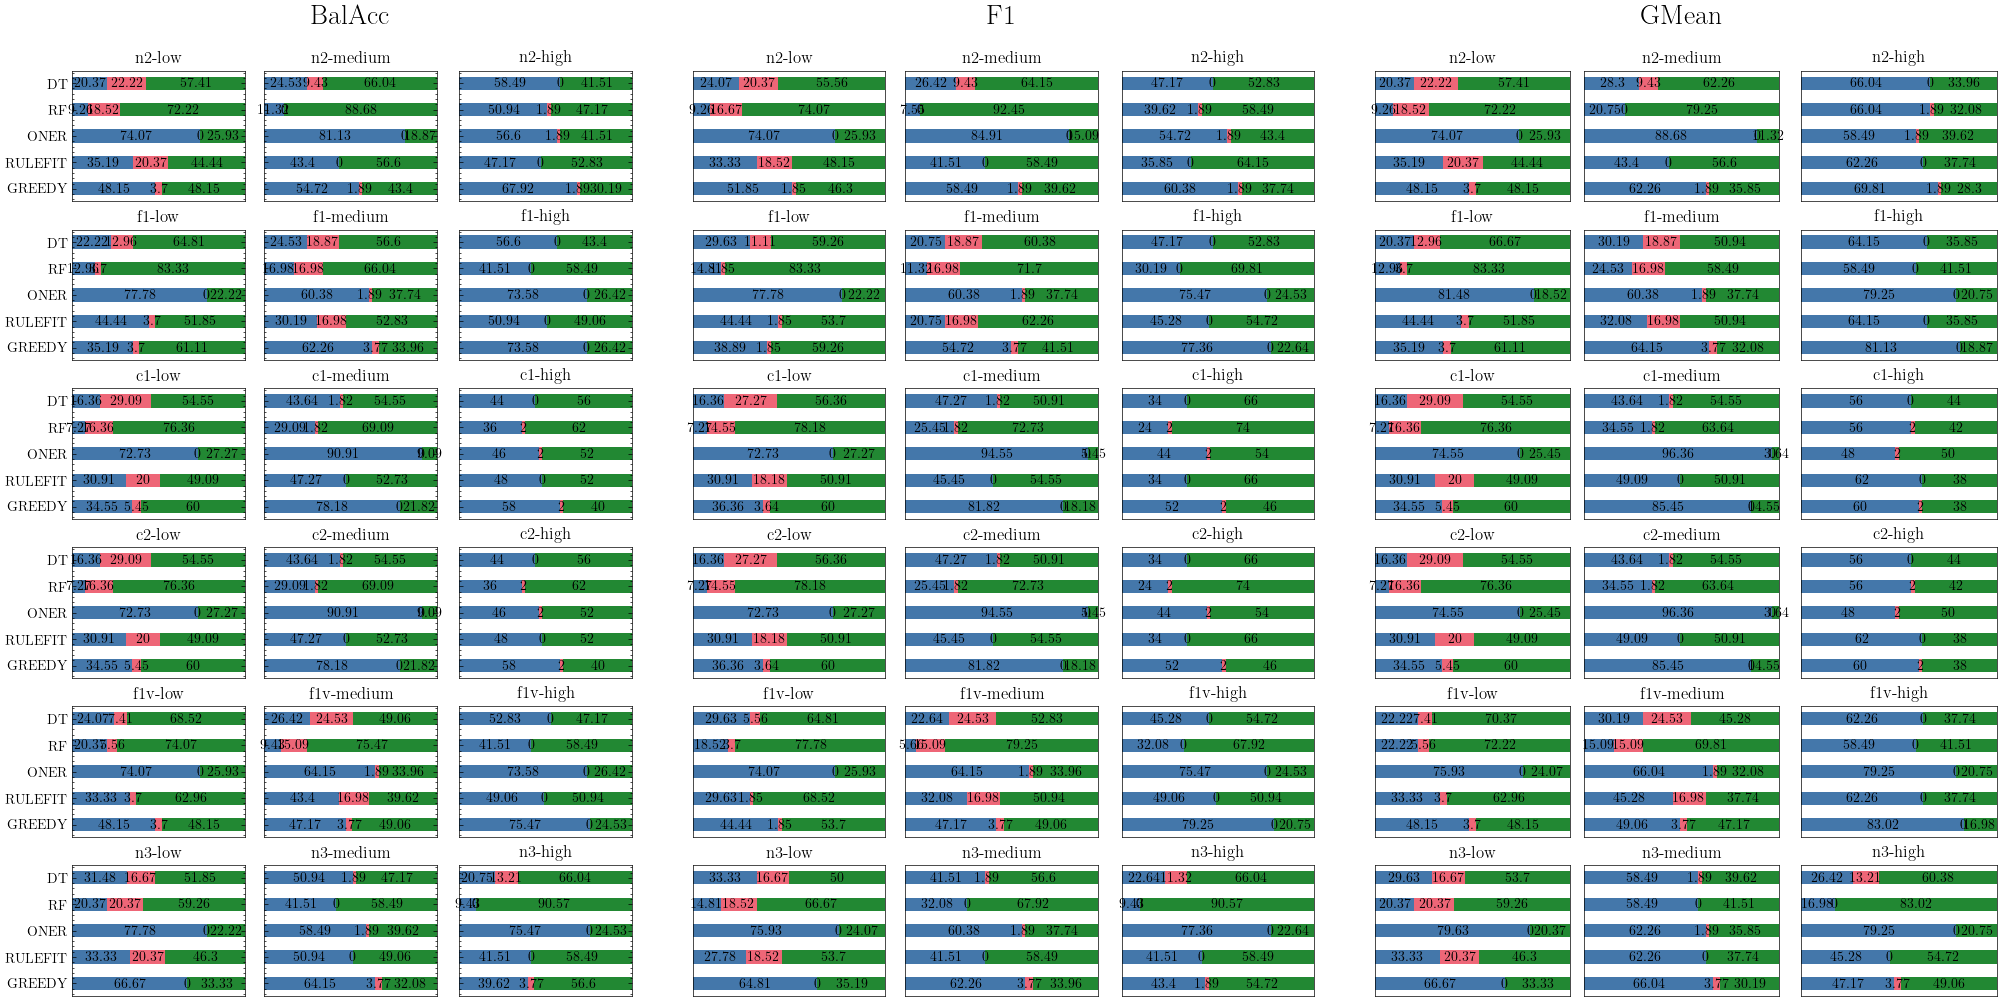

In [56]:
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 3, wspace=0.07)


for labels, subfig in zip([ACC_LABELS, F1_LABELS, GMEAN_LABELS], subfigs):
    axes = subfig.subplots(len(COMPLEXITIES_TO_CONSIDER), 3, sharey="row")
    axes = axes.reshape(-1)
    
    axes_iter = iter(axes)
    for complexity in COMPLEXITIES_WITH_HIGHEST_VARIANCE:
        plot_labels = [l.split('_')[-1].upper() for l in labels]
        
        
        for value in ['low', 'medium', 'high']:
    
            ax = next(axes_iter)
            vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in make_sure_all_labels_are_there(optimal_centroids_df.query(LIMITING_QUERY).query(f"`{complexity}-discretized` == '{value}'")[labels].apply(pd.Series.value_counts)).fillna(0).to_dict().items()}
    
            data = np.array(list(vals_to_plot.values()))
            data_cum = data.cumsum(axis=1)
            ax.invert_yaxis()
            ax.xaxis.set_visible(False)
            # ax.yaxis.set_visible(False)
            ax.set_xlim(0, np.sum(data, axis=1).max())
        
            for i, colname in enumerate(['better', 'equal', 'worse']):
                widths = data[:, i]
                starts = data_cum[:, i] - widths
                rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
                ax.bar_label(rects, label_type='center')
        
            ax.set_title(f"{complexity}-{value}")


for subfig, title in zip(subfigs, ["BalAcc", "F1", "GMean"]):
    subfig.axes[1].annotate(title, (0.5, 1), xytext=(0, 30),
                   textcoords='offset points', xycoords='axes fraction',
                   ha='center', va='bottom', size=20)

for subfig in subfigs[1:]:
    for ax in subfig.axes:
        ax.yaxis.set_visible(False)


# handles, labels = subfigs[-1].axes[-1].get_legend_handles_labels()
# subfigs[-1].legend(handles, labels, loc='lower center')
# fig.savefig('../figures/optimal/accuracy-with-variance-complexity-metrics-barplot.pdf')


## Models complexity

In [ ]:
MODEL_COMPLEXITY_LABELS = ['complexity',"complexity_rf", "complexity_dt", 'complexity_rulefit', "complexity_oner", "complexity_greed"]
MODEL_COMPLEXITY_LABELS_WO_RF = ['complexity', "complexity_dt", 'complexity_rulefit', "complexity_oner", "complexity_greedy"]


In [ ]:
[c for c in optimal_centroids_df.columns if "complexity" in c]

In [ ]:
optimal_centroids_df[MODEL_COMPLEXITY_LABELS]

In [ ]:
ALL_DISCRETIZED_METRICS

In [ ]:
optimal_centroids_df\
    .query(LIMITING_QUERY) \
    [['complexity-'] + ALL_DISCRETIZED_METRICS] \
    .melt(metric)\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')[metric].var()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))


optimal_centroids_df.query(LIMITING_QUERY).groupby("overall-complexity")[MODEL_COMPLEXITY_LABELS_WO_RF].mean().plot(kind='bar', stacked=True, ax=ax)


ax.set_xlabel("Overall dataset complexity")
ax.set_ylabel("Mean complexity")
ax.legend(["algorithm", "DT", "RULEFIT", "ONER", "GREEDY"])

fig.savefig('../figures/optimal/overall-model-complexity-barplots.pdf')


In [ ]:
optimal_centroids_df.query(LIMITING_QUERY).groupby("overall-complexity")[MODEL_COMPLEXITY_LABELS_WO_RF].var().plot(kind='bar')

In [ ]:
order = pd.Categorical([ 'low', 'medium', 'high'],ordered=True)

In [ ]:
optimal_centroids_df \
    .query(LIMITING_QUERY) \
    .groupby('overall-complexity')[['complexity_dt', 'complexity']] \
    .mean().transpose()